## **Generative Adversarial Network (GAN) + Score Predictor Network Architecture**

The script contains a GAN for generating new samples, and a feed forward neural network that predicts G3 score given the other features. The purpose of this is to first see if we can create a GAN that accurately creates fake samples that is hard to distinguish from, then see the predictor network accuracy trained on real data only against real and fake data. This exploration of deep learning will help us gain more insight into the data.

## **Imports, Installs, and Environment Setup**

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import StringIO

# Random Seed so script can be simulated on different machines
torch.manual_seed(1)

## **Data Preprocessing**

#### **Categorical to Numeric Feature Conversion**

In [154]:
# Function: Converts all categorical columns to numeric
def X_prep(X):
    X_copy = X.copy()
    for col_name, col_data in X.items():
        if col_data.dtype == 'object':
            encoder = LabelEncoder()
            numeric_col = encoder.fit_transform(col_data)
            X_copy[col_name] = numeric_col

    # assert none of the columns are categorical
    assert all(X_copy[col].dtype != 'object' for col in X_copy.columns)

    return X_copy

#### **Normalization**

In [156]:
# Function: Normalizes each column by ranging the values from [0,1]
def norm(X):
    X_copy = X.copy()
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(X_copy)

## **Preprocessing the Dataset**

In [157]:
excl_cols = ['Fjob', 'Mjob', 'reason', 'Fedu', 'school', 'guardian', 'Walc','G1', 'G2']

data_path = "data//"
data_portugese = "student-por.xlsx"

data = pd.read_excel(data_path + data_portugese).drop(excl_cols, axis=1)

data = X_prep(data)
data = norm(data)
print(f'Data shape: {data.shape}')

# G3 is the last column of the dataset

Data shape: (649, 24)


## **The Discriminator Model**

In [158]:
# Input: Samples
# Output: Real or Fake

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.network(X)

## **Generator Model**

In [159]:
# Input: Random Noise
# Output: Fake data thats indistinguishable from real, in the discriminators eyes.

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.network(X)

## **GAN Training**

In [170]:
# Returns: Average Generator and Discriminator Loss per Epoch
def gan_train(data, generator):
    criterion = nn.BCELoss()

    # Use GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert data to tensors, create batches
    data = torch.tensor(data, dtype=torch.float32)
    data_loader = DataLoader(data, batch_size=32, shuffle=True)

    # Initialize Models & Optimizers
    discriminator = Discriminator(data.shape[1]).to(device)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=.004)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=.002)

    # Train
    loss_per_epoch = []
    for epoch in range(100):
        running_gloss = 0.0
        running_dloss = 0.0
        batches = 0
        for real_data in data_loader:
            real_data = real_data.to(device)
            batch_size = real_data.shape[0]

            # DISCRIMINATOR TRAINING:
            d_optimizer.zero_grad()

            # 1. Get generator output
            noise = torch.randn(batch_size, 64).to(device)
            fake_data = generator(noise)

            # 2. Get discriminator prediction from the fake data
            disc_pred_fake = discriminator(fake_data.detach()).view(-1)

            # 3. Compute fake data loss
            fake_loss = criterion(disc_pred_fake, torch.zeros_like(disc_pred_fake))

            # 4. Get discriminator prediction from the real data
            disc_pred_real = discriminator(real_data).view(-1)

            # 5. Compute real data loss
            real_loss = criterion(disc_pred_real, torch.ones_like(disc_pred_real))

            # 6. Update discriminator
            d_loss = (fake_loss + real_loss) / 2
            d_loss.backward()
            d_optimizer.step()

            running_dloss += d_loss.item()

            # GENERATOR TRAINING:
            g_optimizer.zero_grad()

            # 1. Get fake data from generator
            noise = torch.randn(batch_size, 64).to(device)
            fake_data = generator(noise)

            # 2. Get discriminator prediction
            disc_pred_fake = discriminator(fake_data)

            # 3. Compute loss (loss compared against ones, want the d_pred to train to be labeled as real)
            g_loss = criterion(disc_pred_fake, torch.ones_like(disc_pred_fake))

            # 4. Update generator
            g_loss.backward()
            g_optimizer.step()

            running_gloss += g_loss.item()

            batches += 1

        loss_per_epoch.append([running_gloss / batches, running_dloss / batches])

    return loss_per_epoch

## **GAN Evaluation**

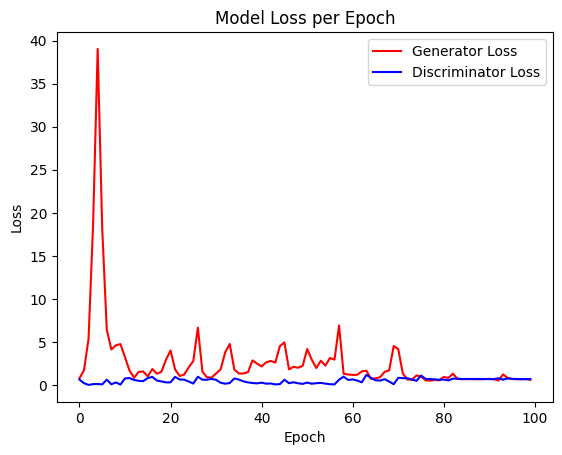

Epoch 0 Generator Loss: 0.7723693223226638
Epoch 50 Generator Loss: 0.597689517906734
Epoch 0 Discriminator Loss: 0.627845945812407
Epoch 50 Discriminator Loss: 0.6958858058566139


In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(64, data.shape[1]).to(device)
losses = np.array(gan_train(data, generator))

gen_losses = losses[:,0]
disc_losses = losses[:,1]

num_epochs = len(losses)

x = np.arange(num_epochs)

# Plot loss over epoch

plt.plot(x, gen_losses, label = "Generator Loss", color = 'red')
plt.plot(x, disc_losses, label = "Discriminator Loss", color = 'blue')
plt.legend()
plt.title("Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.show()

print(f'Epoch 0 Generator Loss: {gen_losses[0]}')
print(f'Epoch 100 Generator Loss: {gen_losses[-1]}')
print(f'Epoch 0 Discriminator Loss: {disc_losses[0]}')
print(f'Epoch 100 Discriminator Loss: {disc_losses[-1]}')

## **GAN Results Interpretation**

After running the GAN with numerous hyperparameters and model architecture, the best loss for the generator and discriminator we could find was around .59-.69 BCELoss for both models. Most of the time, the generator loss curve would oscilate and diverge wildly, while the discriminator loss curve would be more tame but still diverge at times. This tells us that the discriminator is sort of unbeatable, the minimax game being one sided. Which is the exact opposite of what you want. You want the game to be equal so both models can become more accurate, eventually reaching an equilibrium. Our fairly high score but still some slight convergence tells us that the generator is having a hard time estimating the distribution of the data, and the discriminator is easily beating it, not even having to update. It doesnt see the generator as a threat.

**Our Hyperparameters**:
4 Hidden Layer Models (w/ ReLU and Sigmoid)
LR .002 for discriminator & .004 for generator,
100 Epochs,
Batch Size 32

## **Score Predictor Network**

In [179]:
class scorePredictorNet(nn.Module):
    def __init__(self, input_size):
        super(scorePredictorNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, X):
        return self.network(X)

## **Training the Predictor Network**

In [184]:
def predictor_training(data, model):
    # Hyperparameters
    batch_size = 32
    epochs = 50
    criterion = nn.MSELoss()

    # Use GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create DataLoader
    data = torch.tensor(data, dtype=torch.float)
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

    # Initialize Models & Optimizers
    optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

    loss_per_epoch = []

    # Train
    for epoch in range(epochs):
        running_loss = 0.0
        batches = 0
        for i, data in enumerate(data_loader):
            y = data[:, -1]
            X = data[:, :-1]
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y, y_pred)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batches += 1
        loss_per_epoch.append(running_loss / batches)
    return loss_per_epoch

## **Training Predictor Network on Real Data**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


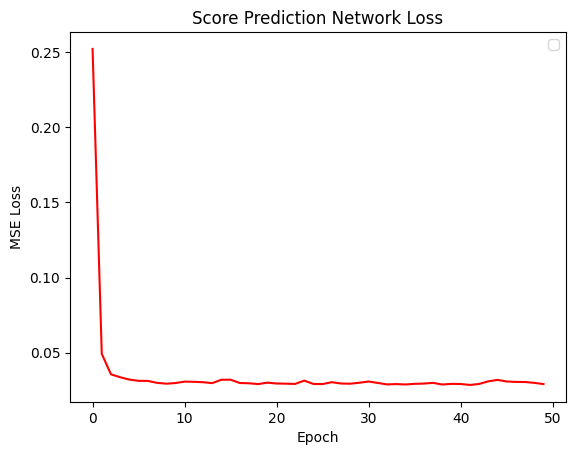

Epoch 0 Training Loss: 0.2520031086390927
Epoch 50 Training Loss: 0.029156869188660665


In [185]:
model = scorePredictorNet(data.shape[1]-1)
losses = np.array(predictor_training(data, model))

num_epochs = np.arange(np.shape(losses)[0])

plt.plot(num_epochs, losses, color = 'red')
plt.legend()
plt.title('Score Prediction Network Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()
print(f'Epoch 0 Training Loss: {losses[0]}')
print(f'Epoch 50 Training Loss: {losses[-1]}')

## **Predictor Network Results**

After running through 50 epochs, we got an MSE loss of .03, which is decent. The only thing that worries us is that the loss drops very fast (basically after the first epoch), and converges very early on. Even with a slow learning rate. This tells us that the features might not be particularly useful for predicting the G3 score, because very different samples could be coming up with the same G3 score. This also tells us that the model doesn't have to work very hard to predict, which means that a simpler model could suffice. Meaning that the features aren't "telling us" anything particularly important. Or that we need more robust data to train on that would give us more insight into patterns.

## **Training Predictor Network on GAN + Real Data**

/Users/jdogtherock/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jdogtherock/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


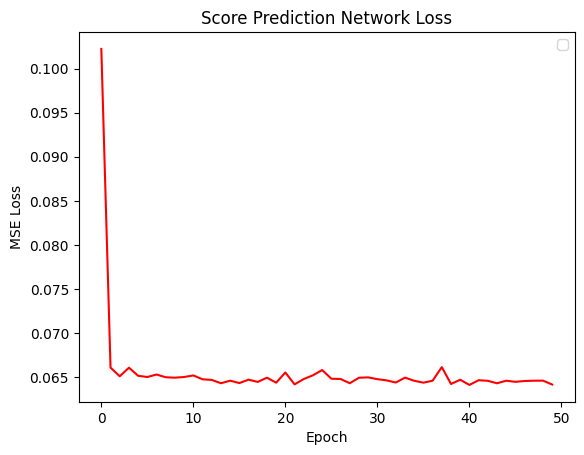

Epoch 0 Training Loss: 0.10222395891096533
Epoch 50 Training Loss: 0.064181216151976


In [193]:
noise = torch.randn(data.shape[0], 64)
fake_data = generator(noise).detach().numpy()

combined_data = np.vstack((data, fake_data))

model = scorePredictorNet(data.shape[1]-1)

losses = np.array(predictor_training(combined_data, model))

num_epochs = np.arange(np.shape(losses)[0])

plt.plot(num_epochs, losses, color = 'red')
plt.legend()
plt.title('Score Prediction Network Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()
print(f'Epoch 0 Training Loss: {losses[0]}')
print(f'Epoch 50 Training Loss: {losses[-1]}')

## **Final Interpretation**

When we train the predictor network on both the real and fake data, the loss curve does not seem very different. However, it is definitely not as stable as the network with only real data trained and the loss after epoch 50 was .064, almost a 2x increase. This tells us that the fake generated data is indeed different from the real, which could make it seem like the GAN was poor. However, this difference in data might be just what we need in order to add "robustness" to the predictor model.

All in all, the predictor network and the GAN performed fairly mediocre and ambiguously. Adding generated data to the training made it have similar loss curve, but a higher loss. But, since it seems like our current data doesnt have much that "stands out" that would make it easy for a model to regress G3 score, the different (and still slightly random) generated data might just be what we need in order to create an overall more robust model, that doesnt just generalize or fail to find underlying patterns. This could be useful if we wanted to use the models on a larger population such as different schools in different countries, or different exams.

Or, maybe a deep learning approach to our hypotheses just isnt the answer.

This exploration goes to show how deep a seemingly simple hypothesis/task can be, and why multiple routes of problem solving has its pros and cons.

## **Possible Future Improvements**

1. More Data
2. Network Complexity
3. Adding Cross Validation
4. Automatic Hyperparameter Tuning